In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

2026-02-24 02:05:58.291597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771898758.492418      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771898758.544629      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771898758.961442      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771898758.961480      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771898758.961483      55 computation_placer.cc:177] computation placer alr

In [2]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 4
EPOCHS = 10
NUM_CLASSES = 21
LEARNING_RATE = 1e-4

DATASET_ROOT = "/kaggle/input/datasets/sajilck/road-segmentation-indian"

print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


In [3]:
CSV_PATH = os.path.join(DATASET_ROOT, "data/index.csv")
df = pd.read_csv(CSV_PATH)[["images", "masks"]]

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    df["images"],
    df["masks"],
    test_size=0.2,
    random_state=42)

In [5]:
CLASS_MAP = {
    "road": 0,
    "sidewalk": 1,
    "building": 2,
    "wall": 3,
    "fence": 4,
    "pole": 5,
    "traffic light": 6,
    "traffic sign": 7,
    "vegetation": 8,
    "terrain": 9,
    "sky": 10,
    "person": 11,
    "rider": 12,
    "car": 13,
    "truck": 14,
    "bus": 15,
    "train": 16,
    "motorcycle": 17,
    "bicycle": 18,
    "background": 19,
    "void": 20
}

In [6]:
def json_to_mask(json_path, height, width):
    mask = np.zeros((height, width), dtype=np.uint8)

    with open(json_path, 'r') as f:
        data = json.load(f)

    for obj in data.get("objects", []):

        label = obj.get("label", "")
        polygon = obj.get("polygon", [])

        if label not in CLASS_MAP:
            continue

        if len(polygon) < 3:
            continue

        class_id = CLASS_MAP[label]

        polygon = np.array(polygon, dtype=np.int32)
        polygon = polygon.reshape((-1, 1, 2))

        cv2.fillPoly(mask, [polygon], class_id)

    return mask

In [7]:
def load_image_mask(image_rel_path, mask_rel_path):

    image_path = os.path.join(DATASET_ROOT, image_rel_path)
    mask_path = os.path.join(DATASET_ROOT, mask_rel_path)

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image / 255.0
    image = image.astype(np.float32)

    # Load mask
    h, w = image.shape[:2]
    mask = json_to_mask(mask_path, h, w)

    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT),
                      interpolation=cv2.INTER_NEAREST)

    mask = tf.keras.utils.to_categorical(mask, NUM_CLASSES)
    mask = mask.astype(np.float32)

    return image, mask

In [8]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_paths, mask_paths,
                 batch_size=BATCH_SIZE, shuffle=True):

        self.image_paths = image_paths.values
        self.mask_paths = mask_paths.values
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):

        batch_indices = self.indices[
            index*self.batch_size:(index+1)*self.batch_size
        ]

        images, masks = [], []

        for i in batch_indices:
            img, mask = load_image_mask(
                self.image_paths[i],
                self.mask_paths[i]
            )
            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [9]:
def conv_block(inputs, filters):
    x = layers.Conv2D(filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


def build_unet(input_shape=(256,256,3), num_classes=21):

    inputs = layers.Input(input_shape)

    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D()(c4)

    c5 = conv_block(p4, 1024)

    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = conv_block(u6, 512)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = conv_block(u7, 256)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding="same")(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = conv_block(u8, 128)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding="same")(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = conv_block(u9, 64)

    outputs = layers.Conv2D(num_classes, 1,
                            activation="softmax")(c9)

    return tf.keras.Model(inputs, outputs)

In [10]:
def mean_iou(y_true, y_pred):

    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)

    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(
        tf.cast(y_true == y_pred, tf.float32)
    )

    return intersection / tf.cast(tf.size(y_true), tf.float32)

In [11]:
model = build_unet((IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES)

model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=[mean_iou]
)

I0000 00:00:1771898914.067880      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [12]:
train_gen = DataGenerator(train_imgs, train_masks)
val_gen = DataGenerator(val_imgs, val_masks, shuffle=False)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3


I0000 00:00:1771898935.526556     146 service.cc:152] XLA service 0x7a8de80041b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771898935.526592     146 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771898937.692722     146 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1771898976.790439     146 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


801/801 ━━━━━━━━━━━━━━━━━━━━ 486s 542ms/step - loss: 2.1117 - mean_iou: 0.4345 - val_loss: 1.3325 - val_mean_iou: 0.5448
Epoch 2/3
801/801 ━━━━━━━━━━━━━━━━━━━━ 418s 521ms/step - loss: 1.2947 - mean_iou: 0.5528 - val_loss: 1.2010 - val_mean_iou: 0.5725
Epoch 3/3
801/801 ━━━━━━━━━━━━━━━━━━━━ 406s 507ms/step - loss: 1.1849 - mean_iou: 0.5763 - val_loss: 1.1397 - val_mean_iou: 0.5965


In [14]:
def visualize_sample(index=0):

    image_path = val_imgs.values[index]
    mask_path = val_masks.values[index]

    image, mask = load_image_mask(image_path, mask_path)

    pred = model.predict(np.expand_dims(image, axis=0))[0]

    pred = np.argmax(pred, axis=-1)
    mask = np.argmax(mask, axis=-1)

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(mask)

    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(pred)

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


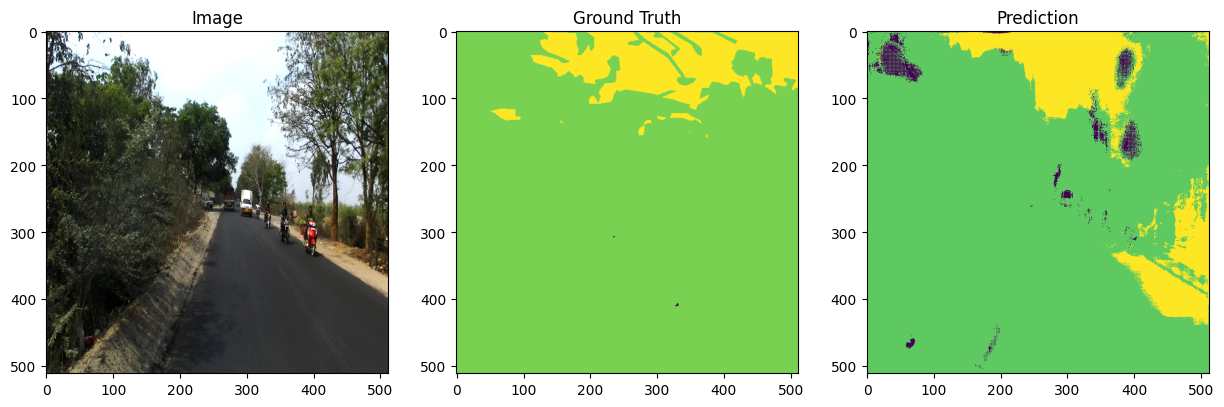

In [21]:
visualize_sample(4)

In [15]:
img, mask = load_image_mask(
    train_imgs.values[0],
    train_masks.values[0]
)

print("Unique classes:",
      np.unique(np.argmax(mask, axis=-1)))

Unique classes: [ 2  5  8 14]
